In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time

In [3]:
df = pd.read_csv('ratings.dat', sep='::', header=None, engine='python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df.head()

user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

In [4]:
df.shape

(1000209, 4)

In [5]:
all_user_cnt = len(df.user_id.unique())
all_user_cnt

6040

In [6]:
all_movies = set(df.movie_id.unique())
all_movie_cnt = len(all_movies)
all_movie_cnt

3706

## Train test split

In [7]:
X, y = df[['user_id', 'movie_id']].values, df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/8, random_state=0)

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(875182, 2) (875182,) (125027, 2) (125027,)


In [9]:
movie_popularity = defaultdict(int)
for _, m_id in X_train:
    movie_popularity[m_id] += 1

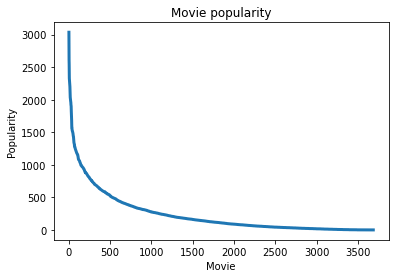

In [10]:
sorted_movie_popularity = sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)
plt.plot(list(map(lambda x: x[1], sorted_movie_popularity)), linewidth=3)
plt.title('Movie popularity')
plt.ylabel('Popularity')
plt.xlabel('Movie')
plt.show()

## User based collaborative filtering

In [11]:
def get_user_movies(data): # all movies that a single user has ratings on
    user_movies = defaultdict(set)
    for u_id, m_id in data:
        user_movies[u_id].add(m_id)
    return user_movies

In [12]:
user_movies_train = get_user_movies(X_train)
user_movies_test = get_user_movies(X_test)

## User similarity calculation

In [13]:
def calc_user_similarity(user_movies): #dict of dict {'u':{'v': score}}
    res = defaultdict(dict)
    user_ids = user_movies.keys()
    for u in tqdm(user_ids):
        for v in user_ids:
            if u < v:
                res[v][u] = res[u][v] = len(user_movies[u] & user_movies[v]) / np.sqrt(len(user_movies[u]) * len(user_movies[v]))
    return res

In [14]:
start = time.time()
user_similarities = calc_user_similarity(user_movies_train)
print(time.time() - start)

100%|██████████| 6040/6040 [02:04<00:00, 48.62it/s] 

124.24386215209961


## Recommend items for a single user

In [15]:
def recommend(user, user_movies, user_similarities, k):
    res = defaultdict(float)
    # calculate k users with the most similarity
    sorted_users = sorted(user_similarities[user].items(), key=lambda x: x[1], reverse=True)
    top_users = sorted_users[:k]
    u_movies = user_movies[user]
    for v, wuv in top_users:
        v_movies = user_movies[v]
        for m_id in v_movies:
            if m_id not in u_movies:
                res[m_id] += wuv * 1.0
    return list(map(lambda x: x[0], sorted(res.items(), key=lambda x: x[1], reverse=True)))

## Performance evaluation

In [16]:
def calc_metrics(user_movies, user_movies_reco, all_movie_cnt, n=None):
    label_all, reco_all, hit = 0, 0, 0
    all_movies_reco = []
    for u_id in user_movies:
        label_movies = user_movies[u_id]
        reco_movies = user_movies_reco[u_id][:n] if n else user_movies_reco[u_id]
        all_movies_reco += reco_movies
        reco_movies = set(reco_movies)
        label_all += len(label_movies)
        reco_all += len(reco_movies)
        hit += len(label_movies & reco_movies)
    return {
        'precision': hit / reco_all,
        'recall': hit / label_all,
        'coverage': len(set(all_movies_reco)) / all_movie_cnt
    }

In [17]:
user_movies_reco = {}
k = 10
for u_id in user_movies_test:
    user_movies_reco[u_id] = recommend(u_id, user_movies_train, user_similarities, k)

In [18]:
calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n = 20)

{'precision': 0.16812802133688948,
 'recall': 0.1613411503115327,
 'coverage': 0.5118726389638424}